In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import scipy
from scipy.constants import c
%matplotlib inline 

mu0 = 1.2566370621219e-6
ep0 = 8.8541878176e-12
v = 1.0/np.sqrt(mu0*ep0)

class dielectric:
    def __init__(self, xmin, xmax, ymin, ymax, er):
      if not(abs(xmax) > Lx or abs(ymax) > Ly):
        assert abs(xmin) < abs(xmax), "x-coordinate order wrong" # Check x-positions
        assert abs(ymin) < abs(ymax), "y-coordinate order wrong" # Check y-positions
        self.xpos = (abs(xmin), abs(xmax))                       # tuple for x-positions
        self.ypos = (abs(ymin), abs(ymax))                       # tuple for y-positions
        self.er = er                                             # relative permittivity
      else:
        print("Dielectric not correct")

In [37]:
class sensor:
    def __init__(self, x, y, type):
      if not(abs(x) > Lx or abs(y) > Ly):
        if not(type < 0 or type > 2):
          self.pos = (float(abs(x)), float(abs(y)))             # tuple for sensor position
          self.measurements = []                                # empty list to append measurement data
          self.type = type                                      # int 0, 1 or 2 for e_z, h_x, and h_y
        else:
          print("Invalid sensor type")
      else:
        print("Invalid sensor position")

    def calculate_position(self, xx, yy):
      # xx is an array containing the possible x-positions
      # yy is an array containing the possible y-positions
      # Note that the possible x- and y-positions are different for different sources.
      if (np.logical_or(self.pos[0]>xx[-1], self.pos[0]<xx[0])):
        print("Warning: requested x-position is out of bounds.")
      if (np.logical_or(self.pos[0]>yy[-1], self.pos[1]<yy[0])):
        print("Warning: requested y-position is out of bounds.")
      self.xi = np.argmin(np.abs(xx-self.pos[0]))
      self.yi = np.argmin(np.abs(yy-self.pos[1]))

    # Changing the class object
    def measurement(self, measure):
        self.measurements.append(measure) # appending a measurement to the list

In [38]:
class source:
  # omega_c = None -> Gaussian pulse
  # omega_c = .... -> modulated Gaussian sinusoidal pulse
  def __init__(self, pos_x, pos_y, J0, delay, pulse_width, omega_c=None):
    if not (abs(pos_x) > Lx or abs(pos_y) > Ly):
      self.pos_x = abs(pos_x)
      self.pos_y = abs(pos_y)
      self.J0 = abs(J0)
      self.delay = abs(delay)
      self.pulse_width = abs(pulse_width)
      self.omega_c = omega_c
    else:
      print("Source location out of bounds")
    
  def current(self,t):
    if self.omega_c is None:
      return self.J0*np.exp(-(t-self.delay)**2.0/(2*self.pulse_width**2.0))
    else:
      return self.J0*np.exp(-(t-self.delay)**2.0/(2*self.pulse_width**2.0))*np.sin(self.omega_c*t)

  def lambda_min(self,er):
    v_min = v/np.sqrt(er)
    if self.omega_c is None:
      omega_max = 3/self.pulse_width
      return 2*np.pi*v_min/omega_max
    else:
      omega_max = 3/self.pulse_width + self.omega_c
      return 2*np.pi*v_min/omega_max

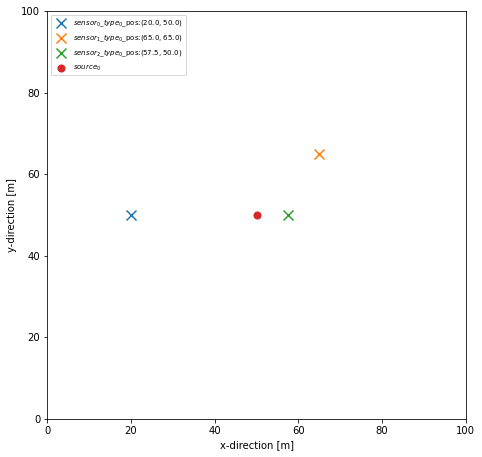

Space discretization steps should be between 0.1046 & 0.157 [m]


In [39]:
# DEFINE MEASUREMENT BOX & SIMULATION PARAMETERS
Lx = 100 # in [m]
Ly = 100 # in [m]
sigma = 5*10**(-9) # [s] 
tc = 3*sigma # [s]
Tmax = 10*tc # in [s]
d = 15

# Include sources
source1 = source(pos_x=Lx/2, pos_y=Ly/2, J0=1, delay=tc, pulse_width=sigma)

j_s = []
j_s.append(source1)

# Include sensors [type: 0 (E_z), 1 (H_x) or 2 (H_y)]
sensor0 = sensor(x=Lx/2-2*d, y=Ly/2, type=0) # E_z sensor in free space
sensor1 = sensor(x=Lx/2+d, y=Ly/2+d, type=0) # E_z sensor in free space
sensor2 = sensor(x=Lx/2+0.5*d, y=Ly/2, type=0) # E_z sensor in free space


sen = []
sen.append(sensor0)
sen.append(sensor1)
sen.append(sensor2)


# Visualize physical space (dielectric(s), source(s), sensor(s)
fig, ax = plt.subplots(figsize=(15*Lx/(Lx+Ly),15*Ly/(Lx+Ly)))

for meetpunt in sen:
    tuple_pos = (meetpunt.pos[0],meetpunt.pos[1])
    ax.scatter(meetpunt.pos[0],meetpunt.pos[1], label=f"$sensor_{sen.index(meetpunt)}$_$type_{meetpunt.type}$_pos:{tuple_pos}",marker="x", s=100)

for bron in j_s:
    ax.scatter(bron.pos_x,bron.pos_y, label=f"$source_{j_s.index(bron)}$", s=50)

plt.legend(fontsize=7, loc="upper left")
plt.xlim([0,Lx])
plt.ylim([0,Ly])
plt.xlabel("x-direction [m]")
plt.ylabel("y-direction [m]")
plt.show()

lambda_min = j_s[0].lambda_min(1)
print("Space discretization steps should be between {min:.4g} & {max:.4g} [m]".format(min=lambda_min/30, max=lambda_min/20))

In [40]:
dx = lambda_min/25
dy = lambda_min/25
Nx = int(Lx/dx + 1)
Ny = int(Ly/dy + 1)
print(f"Number of space discretization steps in x direction: {Nx}")
print(f"Number of space discretization steps in y direction: {Ny}")

max_dt = 1 / (v * np.sqrt(1/(dx**2) + 1/(dy**2)))
print(f"Courant limit for the time step {max_dt} [s]")

dt = max_dt
print(f"Time step: {dt} [s]")
Nt = int(np.floor(Tmax/dt))
print(f"Number of time steps: {Nt}")

Number of space discretization steps in x direction: 797
Number of space discretization steps in y direction: 797
Courant limit for the time step 2.9619219587722447e-10 [s]
Time step: 2.9619219587722447e-10 [s]
Number of time steps: 506


In [41]:
# Discretization of physical space (all free space)
space = np.ones((Nx-1, Ny-1))
space = space[:-1, :-1]

# Calculating the discretized postions of our line source (moet array worden in uitbreiding)
i_source = int(j_s[0].pos_x / dx)
j_source = int(j_s[0].pos_y / dy)


interference_times = np.empty(len(sen))       
for i,meetpunt in enumerate(sen):
    # Initialize measurement sensor
    meetpunt.measurement(0) #mogelijke bug als meetpunt of source ligt
    # Reflection on the PEC walls
    distance = np.empty((4,2))
    distance[0,:] = -meetpunt.pos[0],meetpunt.pos[1]
    distance[1,:] = meetpunt.pos[0],-meetpunt.pos[1]
    distance[2,:] = 2*Lx - meetpunt.pos[0], meetpunt.pos[1]
    distance[3,:] = meetpunt.pos[0],2*Ly- meetpunt.pos[1]
    distance -= (j_s[0].pos_x, j_s[0].pos_y)
    distance = np.linalg.norm(distance,axis=-1)
    min_distance = np.min(distance)
    # Set interference time
    interference_times[i] = min_distance/v
    
# Initialize fields space
ez = np.zeros((Nx,Ny))   # x-component magnetic field [V/m]
hx = np.zeros((Nx,Ny-1)) # y-component magnetic field [V/m]
hy = np.zeros((Nx-1,Ny)) # z-component electric field [V/m]

In [42]:
# Calculate the sensor positions in terms of steps
sensor_pos_x = np.asarray([meetpunt.pos[0] for meetpunt in sen])//dx
sensor_pos_y = np.asarray([meetpunt.pos[1] for meetpunt in sen])//dy
# Calculating the discretized postions of our line source (moet array worden in uitbreiding)
i_source = int(j_s[0].pos_x / dx)
j_source = int(j_s[0].pos_y / dy)

def visualize_field(field, title, title_x, title_y, filename=None):
    plt.figure(figsize = (15,8))
    plt.scatter(sensor_pos_x, sensor_pos_y, c="gray", label="sensors", marker="x")
    plt.scatter(j_s[0].pos_x//dx, j_s[0].pos_y//dy, c="red", label="source point", s=7)
    im = plt.imshow(np.transpose(field), origin='lower')
    plt.title(title)
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    plt.legend(bbox_to_anchor=(1,1), loc='upper left')
    if filename is not None:
        #plt.imsave("./plots/" + filename + ".png", np.transpose(field)) #sneller
        fig = plt.gcf()
        fig.set_size_inches(15,8)
        fig.savefig("./plots/" + filename + ".png") #dit geeft wel mooiere figuur
    plt.close()

def update(iteration,visualize=False):
    # Update Hy
    hy[:,:] += dt/(mu0*dx)*(ez[1:,:]-ez[:-1,:])
    # Update Hx
    hx[:,:] -= dt/(mu0*dy)*(ez[:,1:]-ez[:,:-1])
    # Update E_z
    ez[1:-1,1:-1] += dt/(ep0*dx)*(hy[1:, 1:-1] - hy[:-1, 1:-1])/space
    ez[1:-1, 1:-1] -= dt / (ep0*dy) * (hx[1:-1, 1:] - hx[1:-1, :-1]) /space
    # Update source
    ez[i_source, j_source] -= j_s[0].current((iteration-1/2)*dt)*dt / (dx*dy*ep0*space[i_source, j_source])
       
    # Saving measurement for measurement points
    for meetpunt in sen:
        i, j = int(meetpunt.pos[0]/dx), int(meetpunt.pos[1]/dy)
        # int 0, 1 or 2 for e_z, h_x, and h_y
        if meetpunt.type == 0:
            E_z = ez[i, j] 
            meetpunt.measurement(E_z)
        elif meetpunt.type == 1:
            H_x = hx[i, j]
            meetpunt.measurement(H_x)
        elif meetpunt.type == 2:
            H_y = hy[i, j]
            meetpunt.measurement(H_y)
        else:
            print("Sensor type not known")
    if visualize == 1 or visualize == 3:
        visualize_field(field=abs(ez), title=f"$E_z$ t={iteration*dt} s", title_x = "i (x-axis)", title_y="j (y-axis)", filename=f"Ez/Ez-{iteration:06d}")      
    if visualize ==2 or visualize == 3:
        visualize_field(field=np.sqrt(hx[1:,]**2 + hy[:,1:]**2), title=f"H t={iteration*dt} s", title_x = "i (x-axis)", title_y="j (y-axis)", filename=f"H/H-{iteration:06d}")
        
    if iteration % (Nt//4) == 0 and iteration > 0:
        print("(Another) 1/4 done")

In [43]:
# INPUT WHETHER VISUALIZATION OF THE FIELDS IS PREFERRED (Note: takes quite a while (order of minutes depending on specifications) + saves alot of images in a folder)
visualize_fields = 0        # (0): no visualization [recommended], (1): visualize only E-field, (2): visualize only H-field, (3): visualize both E- and H-fields
add_stopcondition = 1       # (0): keep simulating Nt times, (1): stop simulating if reflections off PEC walls arrive on measurement points [recommended]
# -----------------------
import os
if visualize_fields == 1 or visualize_fields == 3:
    path = os.path.abspath(os.getcwd())
    if not os.path.isdir(f"{path}/plots/Ez"):
        os.mkdir("plots/Ez")
if visualize_fields == 2 or visualize_fields == 3:
    path = os.path.abspath(os.getcwd())
    if not os.path.isdir(f"{path}/plots/H"):
        os.mkdir("plots/H")

print(f"Iterating {Nt} times through the iterative algoritm to update the fields")
if add_stopcondition:
    stop_condition = np.min(interference_times)*1.5 # simulate tiny bit extra
for it in range(Nt):
    update(it,visualize=visualize_fields)
    if add_stopcondition:
        if it*dt > stop_condition:
            print(f"Stop condition reached after {it} iterations: reflections of PEC walls arrive")
            break

Iterating 506 times through the iterative algoritm to update the fields
(Another) 1/4 done
(Another) 1/4 done
(Another) 1/4 done
(Another) 1/4 done


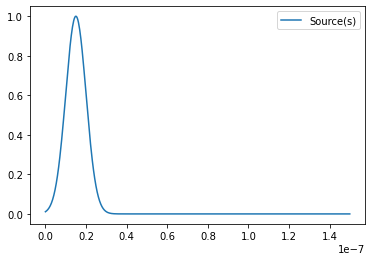

In [44]:
# Discrete time steps for H- and E-measurements
time_H = (np.arange(Nt+1) + 1/2) * dt
time_E = np.arange(Nt+1) * dt

sensor_type_count = np.zeros(3)
minmax = np.zeros(6)
for meetsensor in sen:
    sensor_type_count[meetsensor.type] = sensor_type_count[meetsensor.type] + 1
    min = np.min(meetsensor.measurements)
    max = np.max(meetsensor.measurements)
    if min < minmax[meetsensor.type]:
        minmax[meetsensor.type] = min
    elif max > minmax[meetsensor.type+3]:
        minmax[meetsensor.type+3] = max

plt.figure()
plt.plot(time_E,j_s[0].current(time_E), label="Source(s)")
plt.legend()
plt.show()

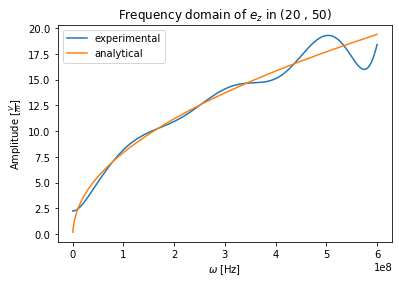

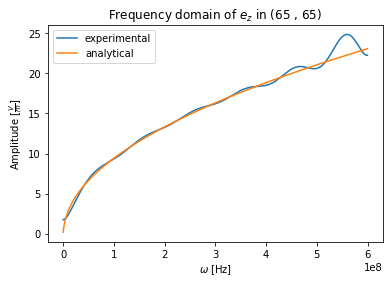

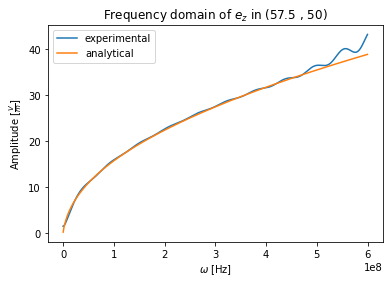

In [45]:
from scipy.special import hankel2

def E_z_hankel(x, y, omega):
    z = omega/v*np.sqrt((x-source1.pos_x)**2 + (y-source1.pos_y)**2)
    E_z = -source1.J0*mu0*omega/4 * sp.hankel2(0,z)
    return E_z

def fourier(omega):
    fourier = source1.J0*np.sqrt(2*np.pi)*sigma*np.exp(-(sigma**2)*(omega**2)/2)
    return fourier

pad_zeros = 100000
reffreq = np.fft.rfftfreq(pad_zeros, d=dt)*2*np.pi # array of omega
use_indices = np.where((reffreq >= (-3/sigma)) & (reffreq <= (3/sigma))) #enkel gewenste frequenties
reffreq = reffreq[use_indices]


for i,meetpunt in enumerate(sen):
    h = E_z_hankel(meetpunt.pos[0], meetpunt.pos[1], reffreq)
    exp = meetpunt.measurements[:int(interference_times[i]//dt)]
    meas_e = np.fft.rfft(exp, n=pad_zeros)*dt
    meas_e = meas_e[use_indices]

    plt.plot(reffreq, abs(meas_e)/fourier(reffreq), label="experimental")
    plt.plot(reffreq, abs(h), label="analytical")
    plt.xlabel(r"$\omega$ [Hz]")
    plt.ylabel(r"Amplitude [$\frac{V}{m}$]")
    plt.title(r"Frequency domain of $e_z$ in ({:g} , {:g})".format(meetpunt.pos[0], meetpunt.pos[1]))
    plt.legend()
    plt.show()